In [1]:
from __future__ import print_function, division

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path
import copy
import torchsummary
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm
#from barbar import Bar
import pickle
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, cohen_kappa_score
cudnn.benchmark = True
plt.ion()   # interactive mode

selected_gpu = 1 # here you select the GPU used (0, 1 or 2)
device = torch.device("cuda:" + str(selected_gpu) if
torch.cuda.is_available() else "cpu")
print(f'the device is {device}')


the device is cuda:1


In [2]:
#if running locally
notebook_path = Path().cwd()
#if running in colab
# from google.colab import drive
# drive._mount('/content/drive')
#notebook_path = Path('/content/drive/MyDrive/MAIA/3rd_semester/CAD/Projecte/Deep_Learning/notebooks')

project_path = notebook_path.parent
repo_path = project_path.parent
os.chdir(notebook_path)
print(f'The current directory is {Path().cwd()}')

The current directory is /home/user7/skin_lesion_classification/Deep_Learning/notebooks


In [3]:
def get_outputs(model:nn.Module, num_classes:int, set_dataloader:DataLoader, device:torch.device):
    """give model and dataloader, return the outputs

    Args:
        model (nn.Module): pretrained model
        num_classes (int): number of classes
        set_dataloader (DataLoader): dataloader of the set
        device (torch.device): device to perform the operation

    Returns:
        np.ndarray: array with the outputs (not predicted labels)
    """
    #pridict and append prediction inan effective way
    with torch.no_grad():
        #set model to evaluation mode
        model.eval()
        #create numpy array to store predictions
        y_pred = np.empty((0, num_classes))
        #go through all the data in dataloader
        for inputs, labels in tqdm(set_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            #run forward pass
            outputs = model(inputs)
            #concatenate predictions
            y_pred = np.concatenate((y_pred, outputs.cpu().numpy()), axis=0)
    return y_pred

def read_pickle(path:Path):
    """read pickle file

    Args:
        path (Path): path to the pickle file

    Returns:
        [type]: [description]
    """
    with open(path, 'rb') as f:
        return pickle.load(f)

# MAIN

## Accuracy and loss

### Binary

#### Notes
- DenseNet121:
    - Best accuracy 0.88 at epoch 6 eq
    - Same at epoch 25 but with 0.94 in for class zero (nevus)
- Efficient net b7:
    - Best accuracy 91.28 at epoch 15 eq
    - There is also a unbalanced accuracy of 0.93 for class zero (nevus)
- RegNetX_200MF:
    - Poor accuracy because it trained only 8 epochs
- ResNet34:
    - Best acc 88.56 but unbalanced towards class zero (nevus) 91
    - The other is just less quality
- VGG19 BN
    - Best acc 87.61 partially balanced epoch 13
    - Best acc 87.98 but unbalanced towards class zero (nevus) epoch 15
    

        loss  val_loss  accuracy  val_accuracy
0   0.471587  0.359499  0.783613      0.842466
1   0.330486  0.304472  0.857453      0.870917
2   0.270674  0.287124  0.883514      0.879347
3   0.224556  0.287898  0.903587      0.880137
4   0.184272  0.292971  0.921487      0.885406
5   0.157431  0.284615  0.935044      0.890148
6   0.129782  0.296069  0.946890      0.887250
7   0.101654  0.313644  0.957552      0.897260
8   0.087922  0.379233  0.964923      0.893045
9   0.077061  0.330193  0.971504      0.900685
10  0.064203  0.325290  0.975518      0.901212
11  0.054403  0.392197  0.979664      0.906481
12  0.051841  0.355910  0.981046      0.913066
13  0.043944  0.357592  0.983087      0.906744
14  0.037104  0.382024  0.986838      0.907271


Text(0.5, 1.0, 'Efficientnet_b7_epoch15 accuracy')

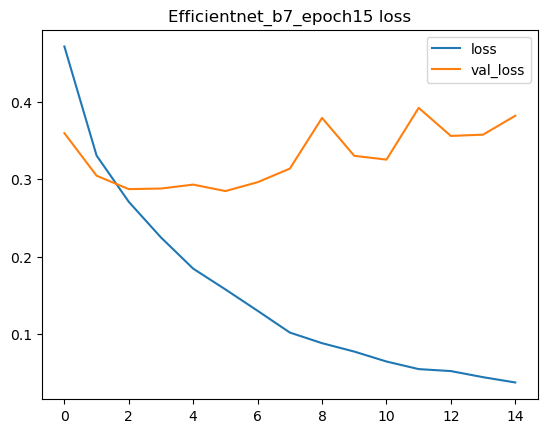

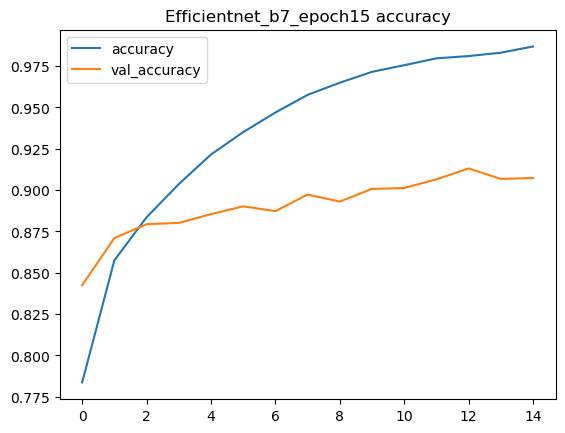

In [21]:
# Let's check the loss and accuracy of the model
model_name = 'efficientnet_b7_epoch15'
with_epoch = False
epoch_num = 9

#see pandas dataframe with more specific info
#read pandas
statistics_path = project_path/ 'data' / 'results' / 'binary'/f'{model_name}_stats.csv'
df = pd.read_csv(statistics_path)
print(df)
#read csv file
df = pd.read_csv(statistics_path)
#plot loss and validation loss
df[['loss', 'val_loss']].plot()
plt.title(f'{model_name.capitalize()} loss')
#plot accuracy and validation accuracy
df[['accuracy', 'val_accuracy']].plot()
plt.title(f'{model_name.capitalize()} accuracy')

### Multiclass

        loss  val_loss  accuracy  val_accuracy  val_kappa
0   0.932123  0.795458  0.726092      0.768504   0.597259
1   0.610800  0.519109  0.784730      0.845669   0.731172
2   0.472186  0.434370  0.831169      0.848819   0.737429
3   0.407422  0.429947  0.854388      0.818110   0.694419
4   0.345612  0.377853  0.878198      0.861417   0.759335
5   0.312710  0.387287  0.887052      0.879528   0.787815
6   0.255579  0.357412  0.908894      0.892126   0.809442
7   0.221726  0.379818  0.921094      0.908661   0.835462
8   0.199020  0.318033  0.930342      0.893701   0.812880
9   0.175229  0.255981  0.936442      0.904724   0.834336
10  0.136846  0.321664  0.952971      0.890551   0.810300
11  0.131197  0.302435  0.950216      0.923622   0.862747
12  0.113055  0.401008  0.956513      0.897638   0.817257
13  0.109734  0.313182  0.961629      0.886614   0.803951
14  0.087629  0.317170  0.966942      0.939370   0.890665
15  0.092054  0.293043  0.967926      0.918898   0.855867
16  0.059543  

Text(0.5, 1.0, 'Regnet_x_16gf_original kappa')

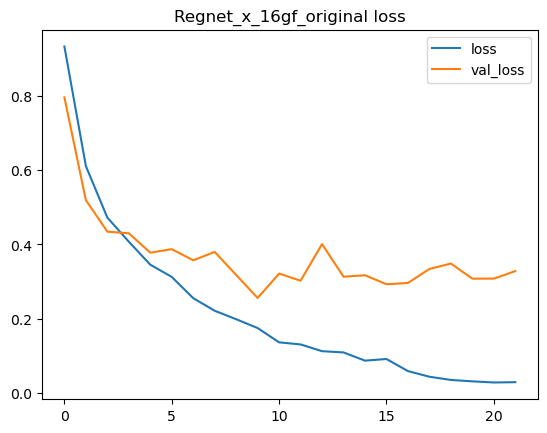

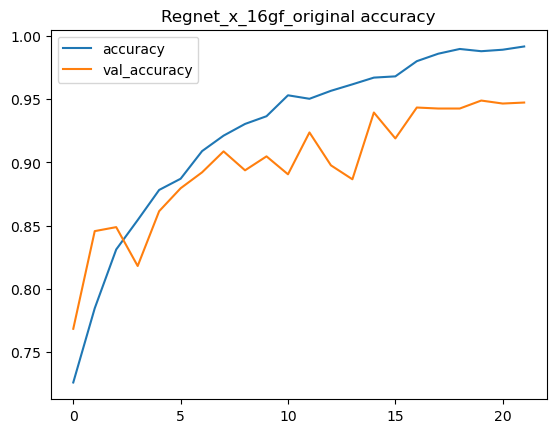

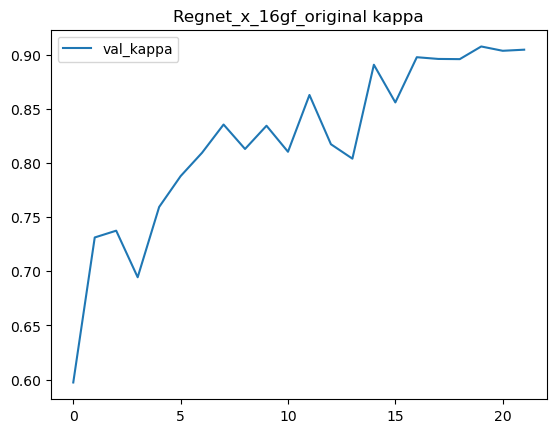

In [73]:
# Let's check the loss and accuracy of the model
# model_name = 'regnet_x_16gf'
model_name = 'regnet_x_16gf_original'
df = pd.read_csv(project_path/ 'data' / 'results' / '3_classes'/ f'{model_name}_stats_multi.csv')
print(df)
#max kappa
# print(f'max kappa: {df["val_kappa"].max()}')

with_epoch = False
epoch_num = 9

#statistics path
statistics_pah = project_path / 'data'/'results' / f'{model_name}_stats_epoch{epoch_num}.csv' if with_epoch else project_path / 'data'/'results' /'3_classes'/ f'{model_name}_stats_multi.csv'
#read csv file
df = pd.read_csv(statistics_pah)
#plot loss and validation loss
df[['loss', 'val_loss']].plot()
plt.title(f'{model_name.capitalize()} loss')
#plot accuracy and validation accuracy
df[['accuracy', 'val_accuracy']].plot()
plt.title(f'{model_name.capitalize()} accuracy')
#plot kappa and validation kappa
df[['val_kappa']].plot()
plt.title(f'{model_name.capitalize()} kappa')

## Metrics

### Binary

#### Setting up data
First define the parameters and the dataloder

In [29]:
#@markdown ## Hyperparameters
batch_size =  4 #@param
num_workers =  2 #@param

#challenge type (binary or 3-classes)
num_classes = 2 #@param

#image size 
height = 450
width = 600

#cropping
center_crop = 448

In [30]:
data_transforms = {
    'val': transforms.Compose([ #for validation we only resize and crop
        transforms.Resize((height, width)),
        transforms.CenterCrop(center_crop),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([ #for test we only resize and crop
        transforms.Resize((height, width)),
        transforms.CenterCrop(center_crop),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
#directory of the data
data_dir = repo_path /'Machine_Learning'/'images' / 'binary'
folders_list = ['val', 'test']

#get the data info
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in folders_list}
#get dataloader
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers) #SHUFFLWE IS OFF
              for x in folders_list}
#size of datasets
dataset_sizes = {x: len(image_datasets[x]) for x in folders_list}
#get classes names
class_names = image_datasets['val'].classes
print(f'the classes for validation are {class_names} and for test are {image_datasets["test"].classes}')

#print info
for key in dataset_sizes.keys():
    print(f'Number of {key} images: {dataset_sizes[key]}')

the classes for validation are ['nevus', 'others'] and for test are ['unknown']
Number of val images: 3796
Number of test images: 6340


#### Check that the data is fine

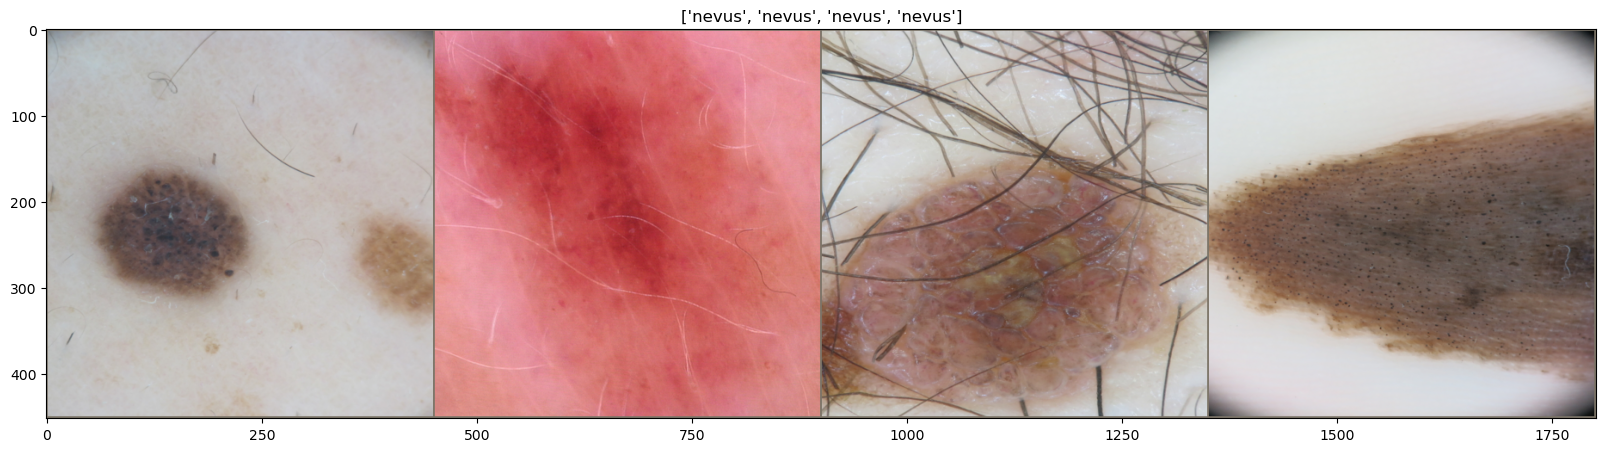

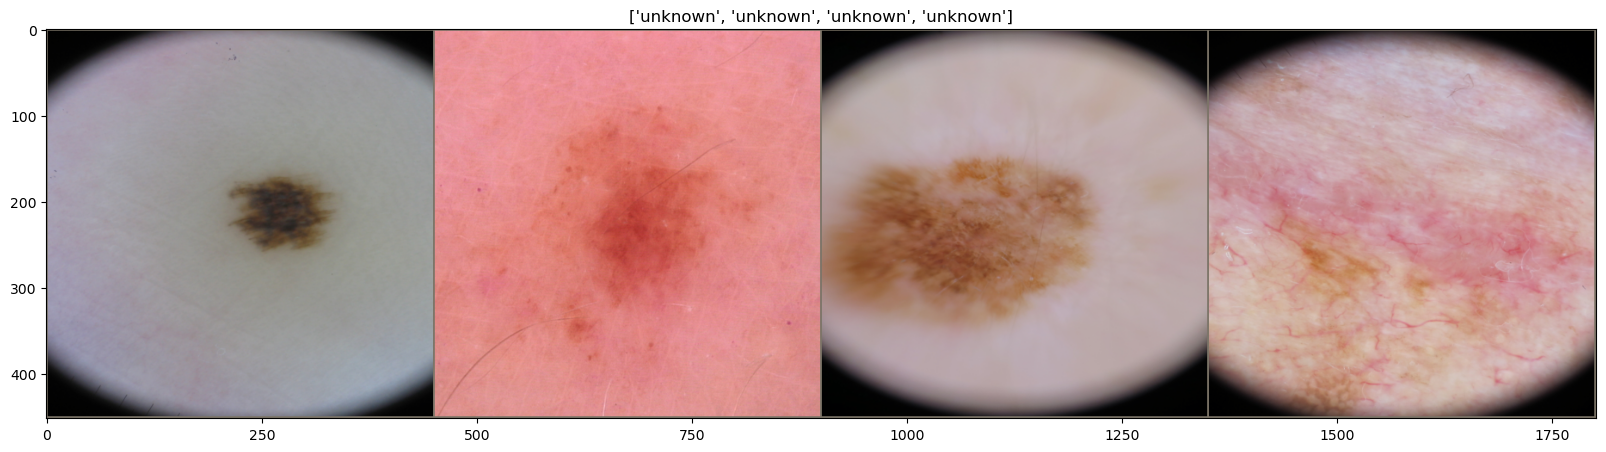

In [146]:
def imshow(input:torch.Tensor, title=None):
    """shows a preprocessed tensor in its original form

    Args:
        input (torch.Tensor): input tensor
        title (_type_, optional): _description_. Defaults to None.
    """
    #get numpy, and put color at the end
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #scale back
    input = std * input + mean
    input = np.clip(input, 0, 1)
    #plot
    plt.figure(figsize=(20,10))
    plt.imshow(input)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of val data
inputs, classes = next(iter(dataloaders['val']))
# Make a grid (fused_image) from batch
out = torchvision.utils.make_grid(inputs)
#show the fused_image
imshow(out, title=[image_datasets['val'].classes[x] for x in classes])

# Get a batch of test data
inputs, classes = next(iter(dataloaders['test']))
# Make a grid (fused_image) from batch
out = torchvision.utils.make_grid(inputs)
#show the fused_image
imshow(out, title=[image_datasets['test'].classes[x] for x in classes])

#### Load model

In [212]:
# Let's check the confusion matrix
model_name = 'efficientnet_b7'
#model weights
model_weights_path = project_path / 'data'/'models'/'binary'/f'{model_name}_epoch15.pt'
#get the model
model = getattr(torchvision.models, model_name)(weights='DEFAULT')

#change last layer to have two outputs
#Densenet classifier
in_fts_fc = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_fts_fc, num_classes)

#load model
model.load_state_dict(torch.load(model_weights_path, map_location=device))
#send to device
model = model.to(device)

#### Predict

In [216]:
set_name = 'test'
#predict on set
outputs = get_outputs(model, num_classes, dataloaders[set_name], device)
#save predictions as pickle
with open(project_path / 'data'/'results'/'binary'/ 'outputs'/f'{model_name}_outputs_{set_name}.pkl', 'wb') as f:
    pickle.dump(outputs, f)

100%|██████████| 1585/1585 [02:10<00:00, 12.13it/s]


#### Confusion matrix

accuracy score is 0.9128029504741834


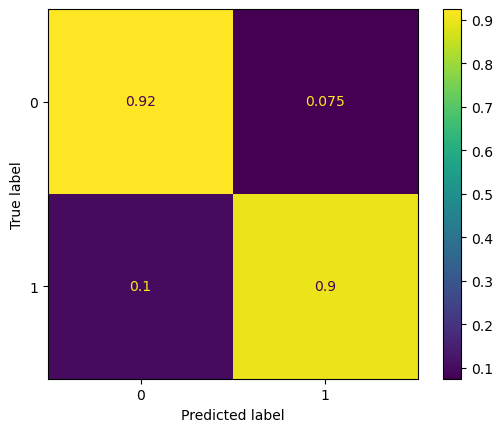

In [215]:
# Get the outputs from pieckle file
with open(project_path / 'data'/'results'/'binary'/ 'outputs' /f'{model_name}_outputs_{set_name}.pkl', 'rb') as f:
    outputs = pickle.load(f)
#get prediction from outputs
pred = np.argmax(outputs, axis=1)
#get labels from dataloader
labels = np.array(image_datasets['val'].targets)

#plot confusion matrix as probability
ConfusionMatrixDisplay.from_predictions(labels, pred, normalize='true')
#get accuracy score
print(f'accuracy score is {accuracy_score(labels, pred)}')

### Multiclass

#### Dataloading

In [4]:
#@markdown ## Hyperparameters
batch_size =  16 #@param
num_workers =  2 #@param

#challenge type (binary or 3-classes)
num_classes = 3 #@param

#image size 
height = 450
width = 600

data_transforms = {
    'val': transforms.Compose([ #for validation we only resize and crop
        transforms.Resize((height, width)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([ #for test we only resize and crop
        transforms.Resize((height, width)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#directory of the data
data_dir = repo_path /'Machine_Learning'/'images' / '3_classes'
folders_list = ['val', 'test']

#get the data info
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in folders_list}
#get dataloader
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers) #SHUFFLWE IS OFF
              for x in folders_list}
#size of datasets
dataset_sizes = {x: len(image_datasets[x]) for x in folders_list}
#get classes names
class_names = image_datasets['val'].classes
print(f'the classes for validation are {class_names} and for test are {image_datasets["test"].classes}')

#print info
for key in dataset_sizes.keys():
    print(f'Number of {key} images: {dataset_sizes[key]}')

the classes for validation are ['bcc', 'mel', 'scc'] and for test are ['unknown']
Number of val images: 1270
Number of test images: 2121


#### Show images

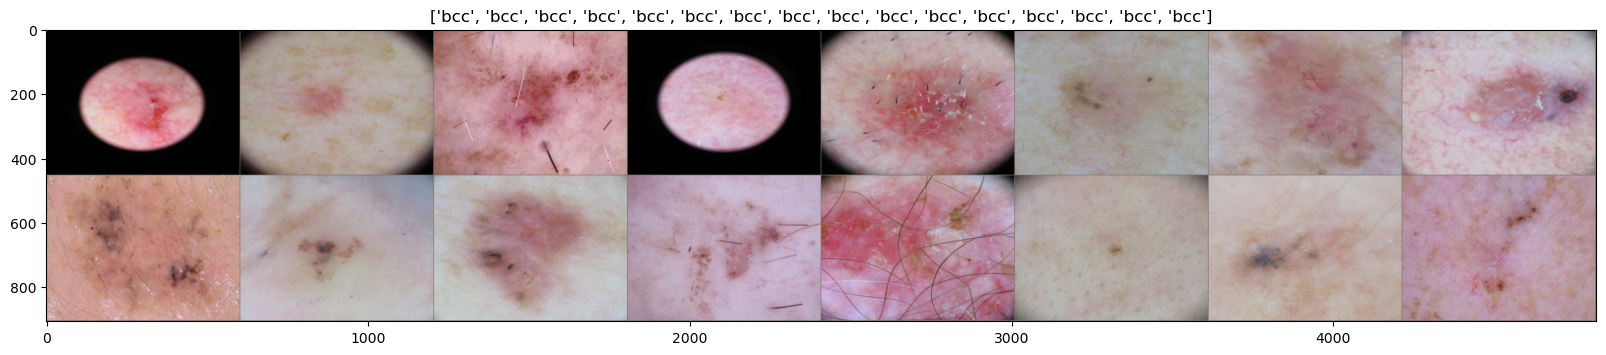

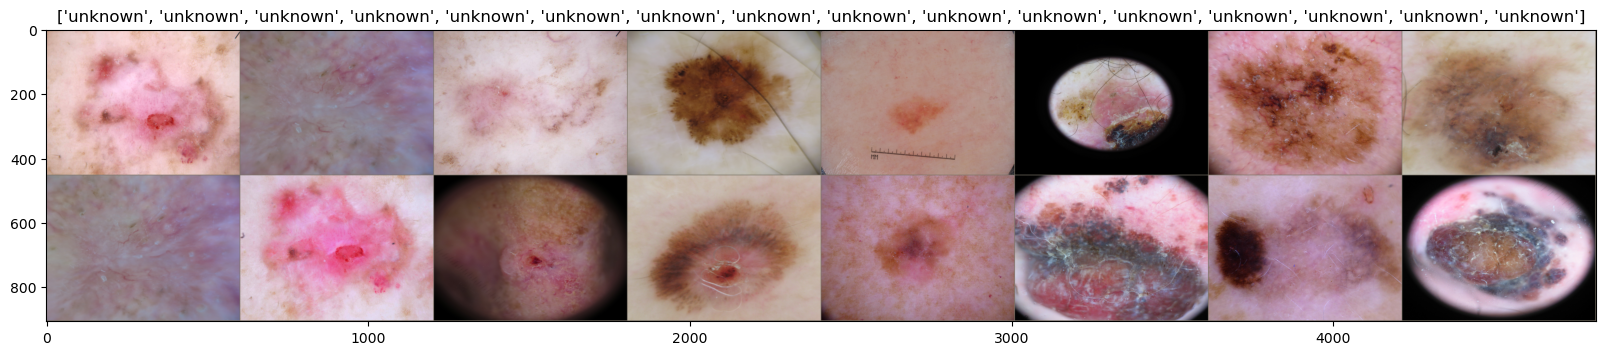

In [20]:
def imshow(input:torch.Tensor, title=None):
    """shows a preprocessed tensor in its original form

    Args:
        input (torch.Tensor): input tensor
        title (_type_, optional): _description_. Defaults to None.
    """
    #get numpy, and put color at the end
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #scale back
    input = std * input + mean
    input = np.clip(input, 0, 1)
    #plot
    plt.figure(figsize=(20,10))
    plt.imshow(input)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of val data
inputs, classes = next(iter(dataloaders['val']))
# Make a grid (fused_image) from batch
out = torchvision.utils.make_grid(inputs)
#show the fused_image
imshow(out, title=[image_datasets['val'].classes[x] for x in classes])

# Get a batch of test data
inputs, classes = next(iter(dataloaders['test']))
# Make a grid (fused_image) from batch
out = torchvision.utils.make_grid(inputs)
#show the fused_image
imshow(out, title=[image_datasets['test'].classes[x] for x in classes])

#### Model

In [60]:
# Let's check the confusion matrix
model_name = 'regnet_x_16gf'
weights_type = 'bestkappa20'
#model weights
model_weights_path = project_path / 'data'/'models'/'3_classes'/f'{model_name}_{weights_type}.pt'
#get the model
model = getattr(torchvision.models, model_name)(weights='DEFAULT')

#change last layer to have two outputs
#Densenet classifier
in_fts_fc = model.fc.in_features
model.fc = nn.Linear(in_fts_fc, num_classes)

#load model
model.load_state_dict(torch.load(model_weights_path, map_location=device))
#send to device
model = model.to(device)

In [61]:
set_name = 'val'
#predict on set
outputs = get_outputs(model, num_classes, dataloaders[set_name], device)
#save predictions as pickle
output_path = project_path / 'data'/'results'/'3_classes'/ 'outputs'/set_name/f'{model_name}_outputs_{weights_type}_{set_name}.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(outputs, f)

In [70]:
set_name = 'val'
model_name = 'regnet_x_16gf'
weights_type = 'bestkappa20'
output_path = project_path / 'data'/'results'/'3_classes'/ 'outputs'/set_name/f'{model_name}_outputs_{weights_type}_{set_name}.pkl'

accuracy score is 0.9488188976377953
best kappa is 0.9075322824908372


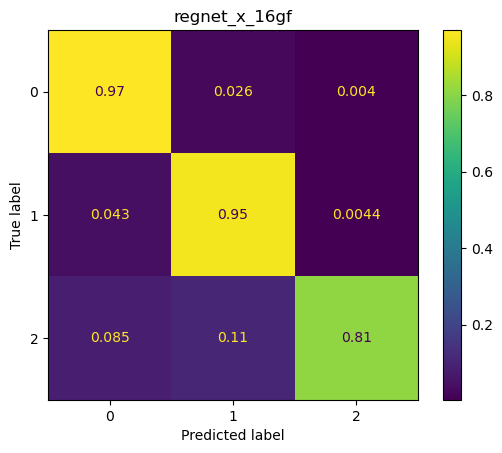

In [71]:
# Get the outputs from pieckle file
with open(output_path, 'rb') as f:
    outputs = pickle.load(f)
#get prediction from outputs
pred = np.argmax(outputs, axis=1)
#get labels from dataloader
labels = np.array(image_datasets['val'].targets)

#plot confusion matrix as probability
ConfusionMatrixDisplay.from_predictions(labels, pred, normalize='true')
plt.title(f'{model_name}')
#get accuracy score
print(f'accuracy score is {accuracy_score(labels, pred)}')
#best kappa
print(f'best kappa is {cohen_kappa_score(labels, pred)}')

## Ensemble

### Binary

We will build ensemble methods to combine the predictions of the models.
We will start with a simple majority vote.

##### Have data again just in case

In [31]:
data_dir = repo_path /'Machine_Learning'/'images' / 'binary'
folders_list = ['val', 'test']

#get the data info
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in folders_list}
#size of datasets
dataset_sizes = {x: len(image_datasets[x]) for x in folders_list}
#get classes names
class_names = image_datasets['val'].classes
print(f'the classes for validation are {class_names} and for test are {image_datasets["test"].classes}')

#print info
for key in dataset_sizes.keys():
    print(f'Number of {key} images: {dataset_sizes[key]}')

the classes for validation are ['nevus', 'others'] and for test are ['unknown']
Number of val images: 3796
Number of test images: 6340


#### Majority vote

In [48]:
#get all outputs from outputs folder
folder_name = project_path / 'data'/'results'/'binary'/ 'outputs'
# #get all files
# models_list = [f for f in os.listdir(folder_name) if os.path.isfile(os.path.join(folder_name, f))]
# #dont consider 'resnet34_outputs-0.pkl'
# models_list = [f for f in models if 'resnet34_outputs-0.pkl' not in f]

#consider only densenet121_outputs_eq.pkl and efficientnet_b7_outputs_eq.pkl
models_list = ['densenet121_outputs_eq.pkl', 'efficientnet_b7_outputs_eq.pkl']
models_list = ['efficientnet_b7_outputs_eq.pkl']
all_preds = np.zeros((len(image_datasets['val']), 0))

for model in models_list:
    #read out
    output_path = project_path / 'data'/'results'/'binary'/ 'outputs' / model
    #get pickle
    outputs = read_pickle(output_path)
    pred = np.argmax(outputs, axis=1)
    #concat in all_preds in column direction
    all_preds = np.concatenate((all_preds, pred[:, None]), axis=1)
#to dataframe
all_preds_df = pd.DataFrame(all_preds)
#perform majority voting in for each row
all_preds_df['majority'] = all_preds_df.mode(axis=1)[0]

accuracy score is 0.9128029504741834


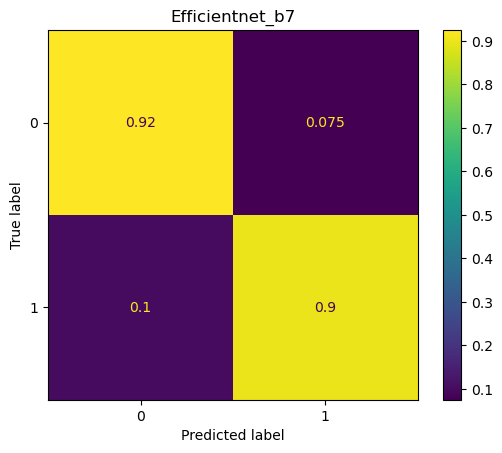

In [50]:
#get only the majority column 
majority_preds = all_preds_df['majority'].values
#compare with labels
labels = np.array(image_datasets['val'].targets)
#plot confusion matrix as probability
ConfusionMatrixDisplay.from_predictions(labels, majority_preds, normalize='true')
plt.title('Efficientnet_b7')
print(f'accuracy score is {accuracy_score(labels, majority_preds)}')

Soft voting

- Each prediction is left as raw output (probability) and summed together

In [37]:
#get all outputs from outputs folder
folder_name = project_path / 'data'/'results'/'binary'/ 'outputs'
set_name = 'val'
models_list = [f'densenet121_outputs_{set_name}.pkl', f'efficientnet_b7_outputs_{set_name}.pkl']

# #get all files
# models_list = [f for f in os.listdir(folder_name) if os.path.isfile(os.path.join(folder_name, f))]
# #dont consider 'resnet34_outputs-0.pkl'
# models_list = [f for f in models_list if 'resnet34_outputs-0.pkl' not in f]

#class_zero probability
class_prob = np.zeros((len(image_datasets[set_name]), 2))
#real labels
labels = np.array(image_datasets[set_name].targets)
for i, name_mod in enumerate(models_list):
    #read out
    output_path = project_path / 'data'/'results'/'binary'/ 'outputs' / name_mod
    #get pickle
    outputs = read_pickle(output_path)
    #prediciton
    pred = np.argmax(outputs, axis=1)
    #get diagonal of confusion matrix
    cm = confusion_matrix(labels, pred, normalize='true')
    cm_diag = np.diag(cm)
    for i in range(2):
        class_prob[:, i] += (outputs[:, i])
    #concat in all_preds in column direction
    #all_preds = np.concatenate((all_preds, pred[:, None]), axis=1)
#divide by number of models
class_prob/=len(models_list)
#get maximum probability
weighted_pred = np.argmax(class_prob, axis=1)

In [35]:
#save weighted predictions as csv file
test_list = image_datasets['test'].imgs
#get only the name
test_list = [os.path.basename(x[0]) for x in test_list]
#remove extension
test_list = [os.path.splitext(x)[0] for x in test_list]
#save column one as the test_list and column two as the weighted_pred
df = pd.DataFrame({'id': test_list, 'label': weighted_pred})
#save data frame as csv without index and header
df.to_csv(project_path / 'data'/'binary_pred.csv', index=False, header=False)

accuracy score is 0.9141201264488936


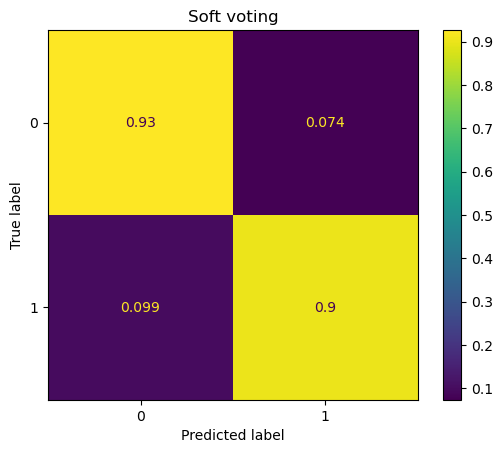

In [38]:
ConfusionMatrixDisplay.from_predictions(labels, weighted_pred, normalize='true')
plt.title('Soft voting')
print(f'accuracy score is {accuracy_score(labels, weighted_pred)}')

### Multiclass

In [5]:
#get all outputs from outputs folder
set_name = 'val'
folder_name = project_path / 'data'/'results'/'3_classes'/ 'outputs' / set_name


#get all files in folder_name
models_list = [f for f in os.listdir(folder_name) if os.path.isfile(os.path.join(folder_name, f))]
#dont consider files that start with regnet_x_32gf_outputs_bestkappa_test.pkl
models_list = [f for f in models_list if f'regnet_x_32gf_outputs_lowestloss_{set_name}.pkl' not in f]
models_list = [f for f in models_list if f'regnet_x_16gf_outputs_lowestloss_{set_name}.pkl' not in f]
models_list = [f for f in models_list if f'regnet_x_16gf_outputs_lowestloss20_{set_name}.pkl' not in f]
#class_zero probability
class_prob = np.zeros((len(image_datasets[set_name]), num_classes))
#real labels
labels = np.array(image_datasets[set_name].targets)
for i, name_mod in enumerate(models_list):
    #read out
    output_path = project_path / 'data'/'results'/'3_classes'/ 'outputs' / set_name/name_mod
    #get pickle
    outputs = read_pickle(output_path)
    #prediciton
    pred = np.argmax(outputs, axis=1)
    #get diagonal of confusion matrix
    cm = confusion_matrix(labels, pred, normalize='true')
    cm_diag = np.diag(cm)
    for i in range(num_classes):
        class_prob[:, i] += (outputs[:, i])
#divide by number of models
class_prob/=len(models_list)
#get maximum probability
weighted_pred = np.argmax(class_prob, axis=1)
weighted_pred

array([0, 0, 0, ..., 1, 2, 2])

kappa score is 0.9173073123417096
accuracy score is 0.9543307086614173


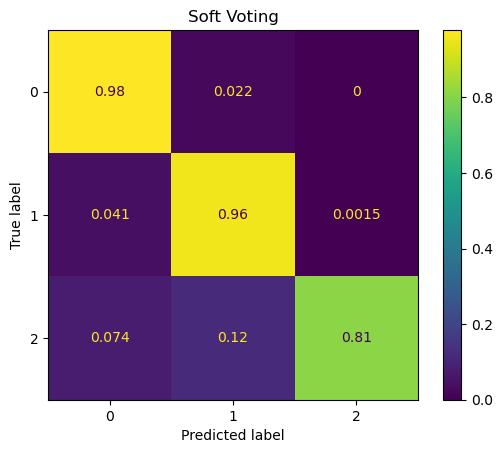

In [6]:
ConfusionMatrixDisplay.from_predictions(labels, weighted_pred, normalize='true')
plt.title('Soft Voting')
print(f'kappa score is {cohen_kappa_score(labels, weighted_pred)}')
print(f'accuracy score is {accuracy_score(labels, weighted_pred)}')

In [53]:
pred_corrected = weighted_pred.copy()
#chnage 0 and 1 in position
pred_corrected[weighted_pred==0] = 1
pred_corrected[weighted_pred==1] = 0
#save weighted predictions as csv file
test_list = image_datasets['test'].imgs
#get only the name
test_list = [os.path.basename(x[0]) for x in test_list]
#remove extension
test_list = [os.path.splitext(x)[0] for x in test_list]
#save column one as the test_list and column two as the weighted_pred
df = pd.DataFrame({'id': test_list, 'label': pred_corrected})
#save data frame as csv without index and header
df.to_csv(project_path / 'data'/'multiclass_pred.csv', index=False, header=False)